# Анализ конверсий клиентов проекта "Тинькофф квест"

In [ ]:
#Импортируем необходимые библиотеки
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
%matplotlib inline

In [220]:
#Подключаемся к базе данных
connection = psycopg2.connect(host = '158.160.52.106', port = 5432, database = 'postgres', 
                              user = 'student', password = 'JvLda93aA')
cursor = connection.cursor()

In [ ]:
#Первоначально будем работать с данными по неделям. В качестве метрики для игр использовала game_flg, потому что 
#нам важно, чтобы игра в целом состоялась (game_flg=1). А удалось её пройти или нет - явно не метрика для конверсии
cursor.execute("with unique_games as( \
	select date_trunc('week', visit_dttm) as action_date, c.client_rk, a.account_rk as regs, \
	a2.account_rk as apps, \
	sum(game_flg) as games \
	from msu_analytics.client c \
    left join msu_analytics.account a using(client_rk) \
    left join msu_analytics.application a2 using(account_rk) \
    left join msu_analytics.game g using(game_rk) \
    group by action_date, a2.account_rk, c.client_rk, a.account_rk \
) \
select action_date, \
count(distinct client_rk) as num_of_visitors, \
count(distinct regs) as num_of_registers, \
count(distinct apps) as num_of_applications, \
sum(case when games > 0 then 1 else 0 end) as num_of_games \
from unique_games \
group by action_date \
order by action_date")
df = cursor.fetchall()
               
df[:5]

In [123]:
#Создаем датасет из полученных данных
funnel_data = pd.DataFrame(df, columns = ['action_date', 'num_of_visitors', 'num_of_registers',
                                         'num_of_applications', 'num_of_games'])
funnel_data.set_index('action_date', inplace=True)
funnel_data.head()

,num_of_visitors,num_of_registers,num_of_applications,num_of_games
action_date,,,,
2022-08-29,111,32,7,5
2022-09-05,184,31,6,5
2022-09-12,167,43,16,8
2022-09-19,181,45,12,11
2022-09-26,195,59,17,17


In [124]:
#Проверяем, что с типами данных все хорошо
funnel_data.dtypes

num_of_visitors        int64
num_of_registers       int64
num_of_applications    int64
num_of_games           int64
dtype: object

In [174]:
#Рассчитываем конверсию относительно пришедших на сайт клиентов
funnel_data['regs_conv'] = round(funnel_data['num_of_registers'] / funnel_data['num_of_visitors'], 2) * 100
funnel_data['apps_conv'] =  round(funnel_data['num_of_applications'] / funnel_data['num_of_visitors'], 2) * 100
funnel_data['games_conv'] = round(funnel_data['num_of_games'] / funnel_data['num_of_visitors'], 2) * 100

In [175]:
#Рассчитываем, сколько клиентов осталось на каждом отдельном этапе и не перешло на другой
funnel_data['only_apps'] = funnel_data['num_of_applications'] - funnel_data['num_of_games']
funnel_data['only_regs'] = funnel_data['num_of_registers'] - funnel_data['num_of_applications']
funnel_data['only_visits'] = funnel_data['num_of_visitors'] - funnel_data['num_of_registers']

Text(0.5, 0, 'Дата')

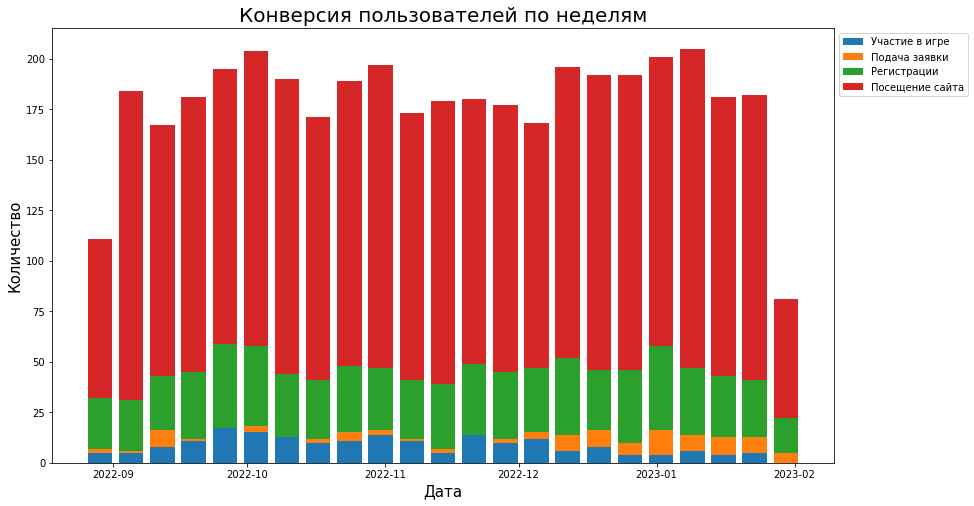

In [195]:
#Смотрим на структуру воронки
plt.figure(figsize=(14,8))

width = 5.5
plt.bar(funnel_data.index, funnel_data['num_of_games'], width=width, 
        label = 'Участие в игре')
plt.bar(funnel_data.index, funnel_data['only_apps'], width=width, bottom = funnel_data['num_of_games'], 
        label = 'Подача заявки')
plt.bar(funnel_data.index, funnel_data['only_regs'], width=width, bottom = funnel_data['num_of_applications'],
       label = 'Регистрации')
plt.bar(funnel_data.index, funnel_data['only_visits'], width=width, bottom = funnel_data['num_of_registers'],
       label = 'Посещение сайта')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Конверсия пользователей по неделям', fontsize = 20)
plt.ylabel('Количество', fontsize=15)
plt.xlabel('Дата', fontsize=15)

На основе графика выше можно сделать следующие выводы:

* До декабря 2022 года в основном пользователи после заявки играли в игру. То есть на этом этапе действительно "отпадало" очень мало пользователей.
* С ростом числа пришедших на сайт пользователей конверсия изменялась незначительно
* После регистрации большинство пользователей заявку НЕ подает

In [ ]:
#Проверим вышеполученные выводы на динамике конверсий
plt.figure(figsize=(14,8))

plt.plot(funnel_data.index, funnel_data['regs_conv'], label = 'Конверсия в регистрацию')
plt.plot(funnel_data.index, funnel_data['apps_conv'], label = 'Конверсия в заявку')
plt.plot(funnel_data.index, funnel_data['games_conv'], label = 'Конверсия в игру')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Динамика недельной конверсии (от количества посещений сайта)', fontsize = 20)
plt.ylabel('Конверсия, %', fontsize=15)
plt.xlabel('Дата', fontsize=15)

Действительно

In [193]:
#Рассчитываем конверсии по иной методике: между этапами
funnel_prev = funnel_data.drop(['regs_conv', 'apps_conv', 'games_conv'], axis = 1)
funnel_prev['regs_conv'] = round(funnel_prev['num_of_registers'] / funnel_prev['num_of_visitors'], 2) * 100
funnel_prev['apps_conv'] = round(funnel_prev['num_of_applications'] / funnel_prev['num_of_registers'], 2) * 100
funnel_prev['games_conv'] = round(funnel_prev['num_of_games'] / funnel_prev['num_of_applications'], 2) * 100

Text(0.5, 0, 'Дата')

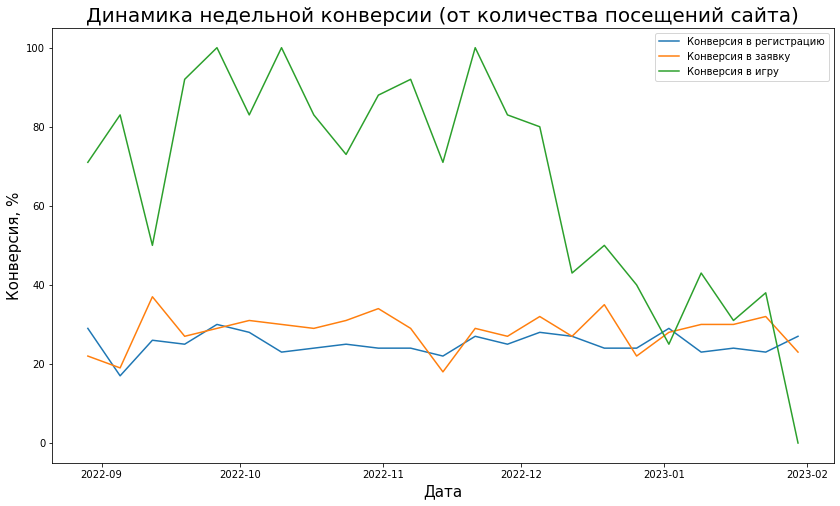

In [194]:
plt.figure(figsize=(14,8))

plt.plot(funnel_prev.index, funnel_prev['regs_conv'], label = 'Конверсия в регистрацию')
plt.plot(funnel_prev.index, funnel_prev['apps_conv'], label = 'Конверсия в заявку')
plt.plot(funnel_prev.index, funnel_prev['games_conv'], label = 'Конверсия в игру')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Динамика недельной конверсии (от предыдущего этапа воронки)', fontsize = 20)
plt.ylabel('Конверсия, %', fontsize=15)
plt.xlabel('Дата', fontsize=15)

In [198]:
cursor.execute("with unique_games as( \
	select date_trunc('month', visit_dttm) as action_date, c.client_rk, a.account_rk as regs, \
	a2.account_rk as apps, \
	sum(game_flg) as games \
	from msu_analytics.client c \
    left join msu_analytics.account a using(client_rk) \
    left join msu_analytics.application a2 using(account_rk) \
    left join msu_analytics.game g using(game_rk) \
    group by action_date, a2.account_rk, c.client_rk, a.account_rk \
) \
select action_date, \
count(distinct client_rk) as num_of_visitors, \
count(distinct regs) as num_of_registers, \
count(distinct apps) as num_of_applications, \
sum(case when games > 0 then 1 else 0 end) as num_of_games \
from unique_games \
group by action_date \
order by action_date")
df2 = cursor.fetchall()
               
df2[:5]

[(datetime.datetime(2022, 9, 1, 0, 0), 778, 190, 51, 39),
 (datetime.datetime(2022, 10, 1, 0, 0), 843, 217, 65, 56),
 (datetime.datetime(2022, 11, 1, 0, 0), 786, 200, 56, 50),
 (datetime.datetime(2022, 12, 1, 0, 0), 805, 196, 57, 33),
 (datetime.datetime(2023, 1, 1, 0, 0), 852, 213, 64, 20)]

In [200]:
funnel_monthly = pd.DataFrame(df2, columns = ['action_date', 'num_of_visitors', 'num_of_registers',
                                         'num_of_applications', 'num_of_games'])
funnel_monthly.set_index('action_date', inplace=True)
funnel_monthly.head()

,num_of_visitors,num_of_registers,num_of_applications,num_of_games
action_date,,,,
2022-09-01,778,190,51,39
2022-10-01,843,217,65,56
2022-11-01,786,200,56,50
2022-12-01,805,196,57,33
2023-01-01,852,213,64,20


In [201]:
#рассчитываю конверсии относительно суммарного кол-ва посетителей
funnel_monthly['regs_conv'] = round(funnel_monthly['num_of_registers'] / funnel_monthly['num_of_visitors'], 2) * 100
funnel_monthly['apps_conv'] =  round(funnel_monthly['num_of_applications'] / funnel_monthly['num_of_visitors'], 2) * 100
funnel_monthly['games_conv'] = round(funnel_monthly['num_of_games'] / funnel_monthly['num_of_visitors'], 2) * 100

funnel_monthly['only_apps'] = funnel_monthly['num_of_applications'] - funnel_monthly['num_of_games']
funnel_monthly['only_regs'] = funnel_monthly['num_of_registers'] - funnel_monthly['num_of_applications']
funnel_monthly['only_visits'] = funnel_monthly['num_of_visitors'] - funnel_monthly['num_of_registers']

Text(0.5, 0, 'Дата')

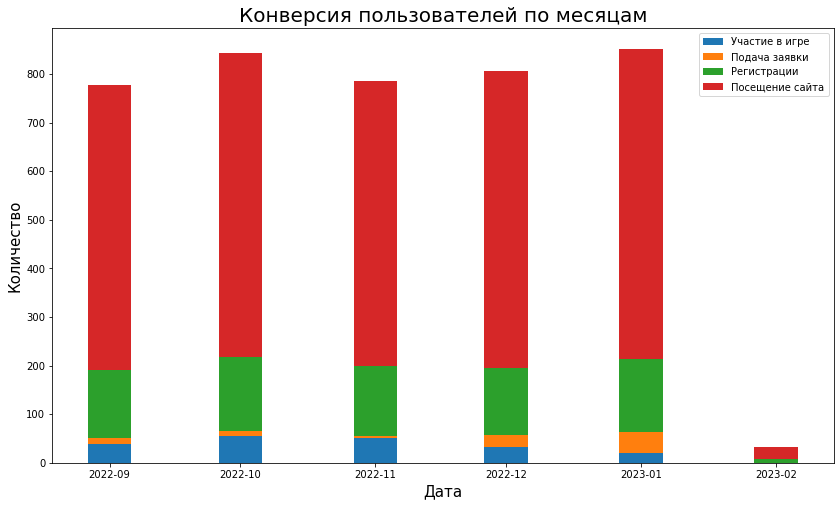

In [204]:
plt.figure(figsize=(14,8))

width = 10
plt.bar(funnel_monthly.index, funnel_monthly['num_of_games'], width=width, 
        label = 'Участие в игре')
plt.bar(funnel_monthly.index, funnel_monthly['only_apps'], width=width, bottom = funnel_monthly['num_of_games'], 
        label = 'Подача заявки')
plt.bar(funnel_monthly.index, funnel_monthly['only_regs'], width=width, bottom = funnel_monthly['num_of_applications'],
       label = 'Регистрации')
plt.bar(funnel_monthly.index, funnel_monthly['only_visits'], width=width, bottom = funnel_monthly['num_of_registers'],
       label = 'Посещение сайта')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Конверсия пользователей по месяцам', fontsize = 20)
plt.ylabel('Количество', fontsize=15)
plt.xlabel('Дата', fontsize=15)

Text(0.5, 0, 'Дата')

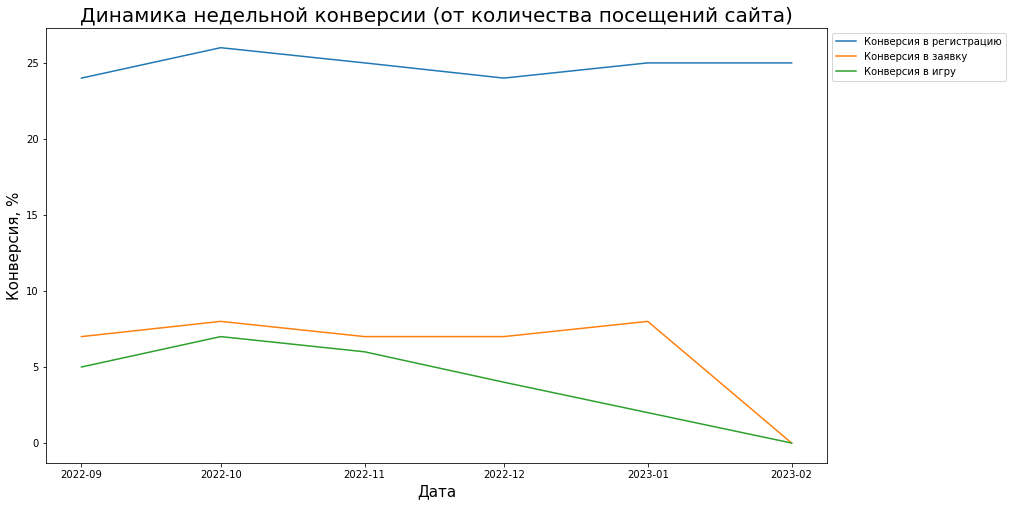

In [205]:
plt.figure(figsize=(14,8))

plt.plot(funnel_monthly.index, funnel_monthly['regs_conv'], label = 'Конверсия в регистрацию')
plt.plot(funnel_monthly.index, funnel_monthly['apps_conv'], label = 'Конверсия в заявку')
plt.plot(funnel_monthly.index, funnel_monthly['games_conv'], label = 'Конверсия в игру')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Динамика недельной конверсии (от количества посещений сайта)', fontsize = 20)
plt.ylabel('Конверсия, %', fontsize=15)
plt.xlabel('Дата', fontsize=15)

In [206]:
#Рассчитываем конверсии по иной методике: между этапами
monthly_prev = funnel_monthly.drop(['regs_conv', 'apps_conv', 'games_conv'], axis = 1)
monthly_prev['regs_conv'] = round(monthly_prev['num_of_registers'] / monthly_prev['num_of_visitors'], 2) * 100
monthly_prev['apps_conv'] = round(monthly_prev['num_of_applications'] / monthly_prev['num_of_registers'], 2) * 100
monthly_prev['games_conv'] = round(monthly_prev['num_of_games'] / monthly_prev['num_of_applications'], 2) * 100

Text(0.5, 0, 'Дата')

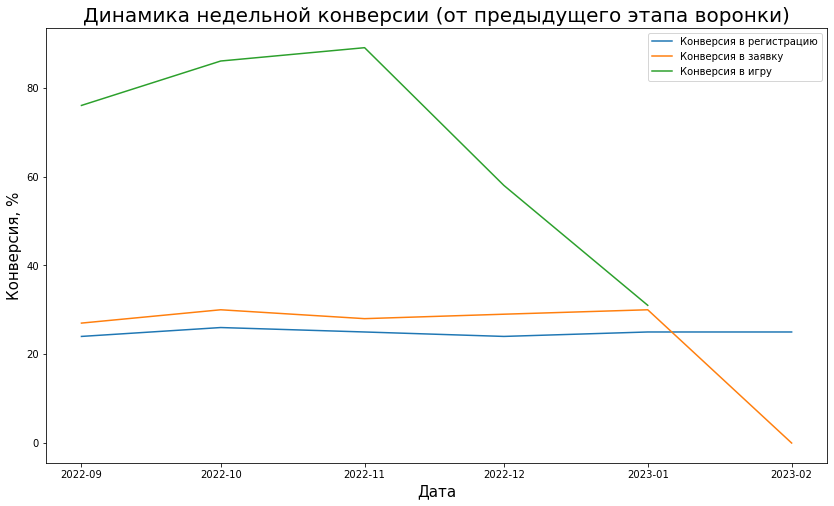

In [207]:
plt.figure(figsize=(14,8))

plt.plot(monthly_prev.index, monthly_prev['regs_conv'], label = 'Конверсия в регистрацию')
plt.plot(monthly_prev.index, monthly_prev['apps_conv'], label = 'Конверсия в заявку')
plt.plot(monthly_prev.index, monthly_prev['games_conv'], label = 'Конверсия в игру')

plt.legend(bbox_to_anchor=(1,1))
plt.title('Динамика недельной конверсии (от предыдущего этапа воронки)', fontsize = 20)
plt.ylabel('Конверсия, %', fontsize=15)
plt.xlabel('Дата', fontsize=15)

Видим резкое снижение конверсии в игру и зявку в феврале 2023 года. Прежде чем пытаться копать, что же там случилось, посмотрим, а что вообше по февралю есть в нашей базе

In [217]:
cursor.execute("select date_trunc('day', visit_dttm), count(distinct c.client_rk), count(distinct a.account_rk) as regs, \
               count(distinct a2.account_rk) as apps, sum(game_flg) as games \
	from msu_analytics.client c \
    left join msu_analytics.account a using(client_rk) \
    left join msu_analytics.application a2 using(account_rk) \
    left join msu_analytics.game g using(game_rk) \
    where visit_dttm > '2023-02-01' \
    group by  date_trunc('day', visit_dttm)") #берем больше 01.02.2023 из-за специфики PostgreSQL
feb = cursor.fetchall()
               
pd.DataFrame(feb, columns = ['action_date', 'num_of_visitors', 'num_of_registers',
                                         'num_of_applications', 'num_of_games'])

,action_date,num_of_visitors,num_of_registers,num_of_applications,num_of_games
0,2023-02-01,27,6,0,None
1,2023-02-02,5,2,0,None


In [218]:
cursor.execute("select max(visit_dttm) \
from msu_analytics.client c")
cursor.fetchall()

[(datetime.datetime(2023, 2, 2, 2, 22, 4, 176738),)]

Действительно, видим, что у нас за февраль данные всего по двум дням. Более того, максимальная дата в датасете - 2 часа ночи 2-го февраля. Следовательно, делать выводы про февраль пока что рано.